## SVM Implementation (reused from previous) on scaled non-reduced dataset

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [7]:
model = SVC(random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7478347768154564
F1 score: [0.77067555 0.71994081]


## Grid Search CV - 1

In [8]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

model = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.7s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   2.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.6s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   2.8s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   3.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.6s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.7s
[CV] END ...................C=0.1, gamma=auto, k

In [9]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                             params  mean_test_score
28     {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.748605
16     {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.746022
18    {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}         0.745773
24    {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.743357
20      {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.743024
8       {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.742524
10     {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}         0.742524
26   {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}         0.738942
21   {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}         0.737360
17  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}         0.737360


Metrics for SVC-baseline-GS-CV1:
Accuracy: 0.7565
Weighted F1: 0.7551
Weighted Precision: 0.7591
Weighted Recall: 0.7565
Macro-Averaged Precision: 0.7600
Macro-Averaged Recall: 0.7540
F1: [0.77787906 0.73055658]
Precision: [0.73775216 0.78216259]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.82      0.78      1556
     Class 1       0.78      0.69      0.73      1446

    accuracy                           0.76      3002
   macro avg       0.76      0.75      0.75      3002
weighted avg       0.76      0.76      0.76      3002

Confusion Matrix


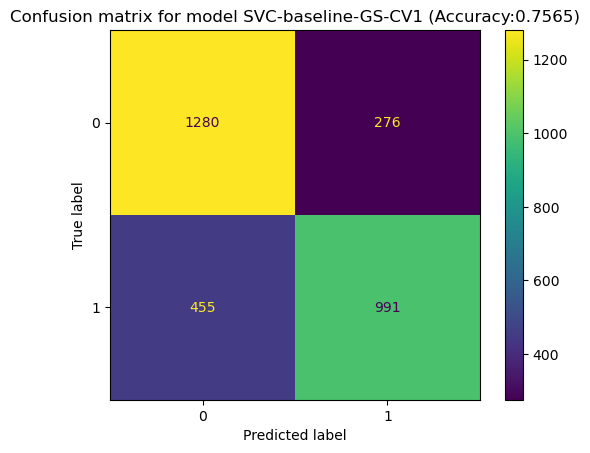

In [10]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('SVC-baseline-GS-CV1', y_test, predictions)

In [11]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = SVC(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7564956695536309
Parameters from place:  1   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7568287808127915
Parameters from place:  2   {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameters: 0.7528314457028648
Parameters from place:  3   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7558294470353097
Parameters from place:  4   {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7534976682211859
Parameters from place:  5   {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7478347768154564
Parameters from place:  6   {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameters: 0.7498334443704198
Parameters from place:  7   {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameters: 0.759493670886076
Paramet

In [12]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [13]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.759493670886076
{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


Classification report of best model from alternatives of fine tuning

In [14]:
model = SVC(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

classification_report(y_test, predictions, zero_division=0)


'              precision    recall  f1-score   support\n\n           0       0.75      0.80      0.77      1556\n           1       0.77      0.72      0.74      1446\n\n    accuracy                           0.76      3002\n   macro avg       0.76      0.76      0.76      3002\nweighted avg       0.76      0.76      0.76      3002\n'

Metrics for SVC-baseline-alternatives:
Accuracy: 0.7595
Weighted F1: 0.7590
Weighted Precision: 0.7600
Weighted Recall: 0.7595
Macro-Averaged Precision: 0.7602
Macro-Averaged Recall: 0.7580
F1: [0.77479726 0.74195854]
Precision: [0.75272727 0.76775148]
classification report
              precision    recall  f1-score   support

     Class 0       0.75      0.80      0.77      1556
     Class 1       0.77      0.72      0.74      1446

    accuracy                           0.76      3002
   macro avg       0.76      0.76      0.76      3002
weighted avg       0.76      0.76      0.76      3002

Confusion Matrix


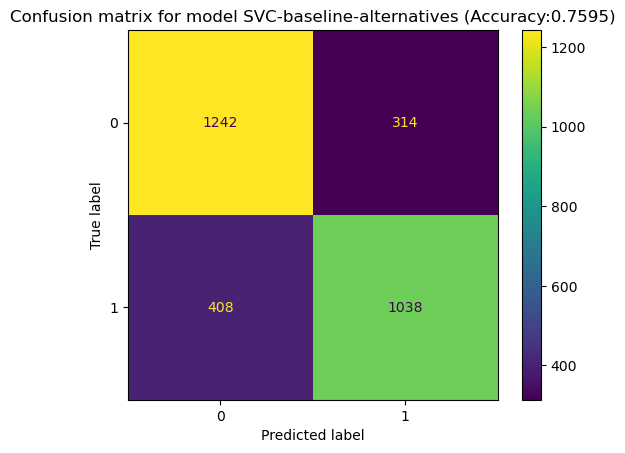

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
SVC-baseline-alternatives,0.759494,0.75898,0.759964,0.759494,0.760239,0.758021,[0.77479726 0.74195854],[0.75272727 0.76775148]


In [15]:
calculate_metrics('SVC-baseline-alternatives', y_test, predictions)